In [1]:
import polars as pl
import numpy as np
from typing import List, Dict

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and not col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        log1p_cols: List[str] = None,
        exclude_cols: List[str] = None,
) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']
        
    if log1p_cols is None:
        log1p_cols = []

    for col in log1p_cols:
        if col in df_to_transforms.columns:
            df_to_transforms = df_to_transforms.with_columns([
                pl.col(col).clip(lower_bound=0.0).log1p().alias(col)
            ])
            
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_month(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = origin_input_df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        origin_input_df.filter(pl.col("month_start") == mt).drop("month_start")
        for mt in unique_months["month_start"]
    ]

    return monthly_dfs

    
def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        # .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_tanh_normalize(
    rollin_df: pl.DataFrame,
    window: int,
    rolling_mean_window: int,
) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_tanh_expr(
            col=column,
            scaled_col=f"{column}_zscaled",
            window=window,
            rolling_mean_window=rolling_mean_window,
        ) for column in columns_to_normalize
    ]) 

def z_score_tanh_expr(
    col: str,
    scaled_col: str,
    window: int,
    rolling_mean_window: int,
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window)
    std_expr = pl.col(col).rolling_std(window).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-3.0, 3.0)
        .tanh()
        .rolling_mean(rolling_mean_window)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
import polars as pl

def fast_build_long_cross_sections(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    long_df = pl.concat(list(symbol_dfs.values()))

    return long_df.sort("timestamp")


In [4]:
def process_single_symbol(
    symbol: str,
    threshold: str = "0.002",
    feat_cal_window: str = "500",
    data_dir: str = "C:/quant/data/binance_resampled_data/",
    feat_trans_window: int = 350,
    feat_trans_lags: list[int] = [5, 10, 20, 50, 100, 150, 200],
    feat_norm_window: int = 500,
    feat_norm_rolling_mean_window: int = 10,
) -> pl.DataFrame:
    symbol.upper()
    
    file = f"{symbol}_factors_threshold{threshold}_rolling{feat_cal_window}.csv"
    path = data_dir + file
    df = pl.read_csv(path)

    # 删掉不需要的列
    df = df.drop([
        "top_acc_longShortRatio", "top_pos_longShortRatio", "acc_longShortRatio"
    ])

    # 对部分列进行 log1p + lag 变换
    cols_to_log1p = [
        "far_bid_price", "far_ask_price",
        "best_bid_price", "best_ask_price",
        "sum_buy_sz", "sum_sell_sz",
        "ts_duration", "real_bid_amount_sum", "real_ask_amount_sum",
    ]
    # df = batch_apply_transforms(df, feat_trans_window, feat_trans_lags, cols_to_log1p)

    # rolling z-score + tanh 归一
    df = rolling_z_tanh_normalize(df, feat_norm_window, feat_norm_rolling_mean_window)

    # 去掉 std=0 的列
    stds = df.select([
        pl.col(col).std().alias(col)
        for col in df.columns
        if df[col].dtype in (pl.Float64, pl.Int64)
    ])
    zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
    df = df.drop(zero_std_cols)

    return df


In [5]:

def filter_valid_cross_sections(long_df: pl.DataFrame, num_symbols: int) -> pl.DataFrame:
    valid_ts = (
        long_df
        .filter(pl.col("px").is_not_null())
        .group_by("timestamp")
        .agg(pl.len().alias("len"))
        .filter(pl.col("len") == num_symbols)
        .select("timestamp")
    )
    return long_df.join(valid_ts, on="timestamp", how="inner")


def build_long_cross_sections_fast(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    # 1. 获取所有币种的所有时间戳，合并去重，得到全局时间轴 timeline
    all_timestamps = (
        pl.concat(
            [df.select("timestamp").unique() for df in symbol_dfs.values()]
        )
        .unique()
        .sort("timestamp")
    )

    result_dfs = []

    for symbol, df in symbol_dfs.items():
        # 确保 df 按时间戳排序
        df_sorted = df.sort("timestamp")
        # 2. 用 timeline 左连接（asof join）当前币种数据，找最近小于等于时间戳的行
        joined = all_timestamps.join_asof(
            df_sorted,
            on="timestamp",
            strategy="backward"  # 小于等于左表时间戳的最近一条右表数据
        )
        # 3. 补充 symbol 列（如果df本身有，确认无误）
        # 如果原始 df 有 symbol，这里确认 symbol 是正确的
        joined = joined.with_columns(pl.lit(symbol).alias("symbol"))
        result_dfs.append(joined)

    long_df = pl.concat(result_dfs).sort(["timestamp", "symbol"])
    clean_df = filter_valid_cross_sections(long_df, len(symbol_dfs))


    return clean_df

In [6]:
from collections import defaultdict

def process_all_symbols(params_dict):
    symbol_dfs = {}
    for sym, param in params_dict.items():
        df = process_single_symbol(
            symbol=sym,
            threshold=param.get("threshold", "0.002"),
            feat_trans_window=param.get("feat_trans_window", 350),
            feat_norm_window=param.get("feat_norm_window", 500),
            feat_norm_rolling_mean_window=param.get("feat_norm_rolling_mean_window", 10),
        )
        df = df.with_columns(pl.lit(sym).alias("symbol"))
        symbol_dfs[sym] = df
        
    return symbol_dfs

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs:", len(weekly_dataframes))

symbol_params = {
    "btcusdt": {
        "threshold": "0.001",
        "feat_trans_window": 200,
        "feat_norm_window": 200,
        "feat_norm_rolling_mean_window": 50,
    },
    "ethusdt": {
        "threshold": "0.002",
        "feat_trans_window": 200,
        "feat_norm_window": 200,
        "feat_norm_rolling_mean_window": 50,
    },
    "dogeusdt": {
        "threshold": "0.002",
        "feat_trans_window": 200,
        "feat_norm_window": 200,
        "feat_norm_rolling_mean_window": 50,
    },
    "tonusdt": {
        "threshold": "0.002",
        "feat_trans_window": 200,
        "feat_norm_window": 200,
        "feat_norm_rolling_mean_window": 50,
    },
}

symbol_dfs = process_all_symbols(symbol_params)

symbol_weekly = {}
max_weeks = 0

# 拆分每个币种的周数据（list），记录最长周数
for sym, df in symbol_dfs.items():
    df = clean_df_drop_nulls(df)
    dfs = split_df_by_week(df)  # 只拿 list
    symbol_weekly[sym] = dfs
    if len(dfs) > max_weeks:
        max_weeks = len(dfs)

result = []

# 遍历所有周（用索引表示周数）
for wk_idx in range(max_weeks):
    week_dict = {}
    for sym, dfs in symbol_weekly.items():
        if wk_idx < len(dfs):
            week_dict[sym] = dfs[wk_idx]
    result.append(week_dict)

print(f"共 {len(result)} 周")
for i, week_dict in enumerate(result):
    print(f"第 {i+1} 周:")
    for sym, df in week_dict.items():
        print(f"  {sym}: {df.shape}")



各列空值数量：
sum_buy_sz_zscaled                              49
sum_sell_sz_zscaled                             49
ts_duration_zscaled                             49
px_pct_zscaled                                  49
bs_imbalance_zscaled                            49
                                                ..
z_factor_oi_breakout_signal_zscaled             49
z_factor_momentum_trend_confirm_zscaled         49
z_factor_order_sentiment_divergence_zscaled     49
z_factor_oi_momentum_punch_zscaled              49
z_factor_oi_momentum_long_term_punch_zscaled    49
Length: 107, dtype: int64
删除空值超过 10000 的列：[]
删除列后，DataFrame形状：(33237, 217)
空值最多的列是：sum_buy_sz_zscaled，共有 49 个空值
删除空值行后，DataFrame形状：(33188, 217)
各列空值数量：
sum_buy_sz_zscaled                              49
sum_sell_sz_zscaled                             49
ts_duration_zscaled                             49
px_pct_zscaled                                  49
bs_imbalance_zscaled                            49
                        

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from tqdm import tqdm

weekly_long_dfs = []

for week_symbol_dfs in tqdm(result):
    long_df = build_long_cross_sections_fast(week_symbol_dfs)  # 就是你写的函数
    weekly_long_dfs.append(long_df)

print(weekly_long_dfs[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.80it/s]

shape: (25_284, 218)
┌───────────────┬──────────┬─────────────┬─────────────┬───┬──────────────────────────────┬─────────────────────────────┬──────────┬──────────────┐
│ timestamp     ┆ px       ┆ sum_buy_sz  ┆ sum_sell_sz ┆ … ┆ z_factor_oi_momentum_punch_z ┆ z_factor_oi_momentum_long_t ┆ symbol   ┆ timestamp_dt │
│ ---           ┆ ---      ┆ ---         ┆ ---         ┆   ┆ sc…                          ┆ erm…                        ┆ ---      ┆ ---          │
│ i64           ┆ f64      ┆ f64         ┆ f64         ┆   ┆ ---                          ┆ ---                         ┆ str      ┆ datetime[ms] │
│               ┆          ┆             ┆             ┆   ┆ f64                          ┆ f64                         ┆          ┆              │
╞═══════════════╪══════════╪═════════════╪═════════════╪═══╪══════════════════════════════╪═════════════════════════════╪══════════╪══════════════╡
│ 1751847727181 ┆ 109035.1 ┆ 821.075     ┆ 1100.045    ┆ … ┆ 0.244963                     ┆

In [33]:
weekly_dataframes = []

le_symbol = LabelEncoder()
all_symbols = set()

N = 1000


# 第一步：提取所有symbol，用于统一label encoding
for df in tqdm(weekly_long_dfs):
    all_symbols.update(df["symbol"].unique())

# 拿全局symbol顺序做LabelEncoder，确保 embedding 一致性
le_symbol.fit(sorted(list(all_symbols)))

for long_df in weekly_long_dfs:
    # 给 symbol 编码
    symbol_encoded = le_symbol.transform(long_df['symbol'].to_list())
    long_df = long_df.with_columns([pl.Series('enc_cat_symbol', symbol_encoded)])
    
    # 加 row_nr
    long_temp_df = long_df.with_row_index(name="row_nr")
    
    # 计算未来收益率
    df_with_future = (
        long_temp_df.sort(["symbol", "timestamp"])
        .group_by("symbol")
        .map_groups(lambda group: group.with_columns([
            group["px"].shift(-N).alias("px_future"),
            (group["px"].shift(-N) / group["px"]).log().alias(f"future_return_{N}")
        ]))
        .sort("row_nr")
        .drop("row_nr")
    )
    
    weekly_dataframes.append(df_with_future)

print(weekly_dataframes[-1])

from sklearn.preprocessing import LabelEncoder

ranked_weekly_dataframes = []

for df in weekly_dataframes:
    rank_df = (
        df.sort("timestamp")
        .group_by("timestamp")
        .map_groups(
            lambda group: group.with_columns([
                group[f"future_return_{N}"]
                .rank("dense", descending=True)
                .alias("rank_label")
            ])
        )
    )
    ranked_weekly_dataframes.append(rank_df)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2258.12it/s]


shape: (25_284, 221)
┌───────────────┬──────────┬─────────────┬─────────────┬───┬─────────────────────────┬────────────────┬───────────┬────────────────────┐
│ timestamp     ┆ px       ┆ sum_buy_sz  ┆ sum_sell_sz ┆ … ┆ timestamp_dt            ┆ enc_cat_symbol ┆ px_future ┆ future_return_1000 │
│ ---           ┆ ---      ┆ ---         ┆ ---         ┆   ┆ ---                     ┆ ---            ┆ ---       ┆ ---                │
│ i64           ┆ f64      ┆ f64         ┆ f64         ┆   ┆ datetime[ms]            ┆ i64            ┆ f64       ┆ f64                │
╞═══════════════╪══════════╪═════════════╪═════════════╪═══╪═════════════════════════╪════════════════╪═══════════╪════════════════════╡
│ 1751847727181 ┆ 109035.1 ┆ 821.075     ┆ 1100.045    ┆ … ┆ 2025-07-07 00:19:55.223 ┆ 0              ┆ 109097.4  ┆ 0.000571           │
│ 1751847727181 ┆ 0.17153  ┆ 2.2908165e7 ┆ 2.5462381e7 ┆ … ┆ 2025-07-07 00:19:55.233 ┆ 1              ┆ 0.17081   ┆ -0.004206          │
│ 1751847727181 ┆ 25

In [41]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "rank_label"

# 用第一个 df 定义 feature_cols
sample_df = ranked_weekly_dataframes[0]
feature_cols = [
    col for col in sample_df.columns
    if (col.endswith("_zscaled") or col == "enc_cat_symbol")
    and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    and not col.startswith("future_return_")
    and col != "rank_label"
    and col != "px"
]

cat_idxs = [feature_cols.index('enc_cat_symbol')]
cat_dims = [sample_df.select('enc_cat_symbol').n_unique()]
cat_emb_dim = 2
print(len(feature_cols), cat_idxs, cat_dims)

100 [99] [4]


In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section(symbols, y_true, y_binary, y_pred_prob, px, alpha=1.0):
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    width = 0.2

    # 真实未来收益（连续）
    ax1.bar(x - width, y_true, width=width, label='Future Return', alpha=0.6)
    ax1.set_ylabel('Future Return')

    # 价格线
    ax2 = ax1.twinx()
    ax2.plot(x, px, label='Price', color='tab:blue', marker='o')
    ax2.set_ylabel('Price')

    # 分类标签（二分类）
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.scatter(x, y_binary, label='GMM Label', color='tab:orange', marker='x')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_ylabel('Binary Label')

    # 预测概率
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    ax4.plot(x, y_pred_prob, label='Predicted Prob', color='tab:green', marker='^')
    ax4.set_ylim(-0.05, 1.05)
    ax4.set_ylabel('Predicted Probability')

    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45)
    ax1.set_xlabel('Symbols')

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.title("Cross-Section Comparison at One Timestamp")
    plt.tight_layout()
    plt.show()


In [51]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

tabnet = None

all_preds = []  # 放到 for 循环外

for i in range(len(ranked_weekly_dataframes) - 2):
    train_df = ranked_weekly_dataframes[i]
    val_df = ranked_weekly_dataframes[i + 1]
    test_df = ranked_weekly_dataframes[i + 2]

    def process_df_np(df):
        df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px'])
        X = df.select(feature_cols).to_numpy()  # Polars DataFrame 转 numpy ndarray
        y = df.select(target_col).to_numpy().astype(int).reshape(-1)
        px = df.select('px').to_numpy()
        ts = df.select('timestamp').to_numpy()
        symbol_enc = df.select("enc_cat_symbol")
        return X, y, px, ts, symbol_enc

    X_train, y_train, px_train, ts_train, sb_train = process_df_np(train_df)
    X_val, y_val, px_val, ts_val, sb_val = process_df_np(val_df)
    X_test, y_test, px_test, ts_test, sb_test = process_df_np(test_df)


    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    

    params = {
        # 模型结构参数
        "n_d": 8,                      # 决策输出维度
        "n_a": 8,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": cat_idxs,               # 类别特征的列索引
        "cat_dims": cat_dims,               # 每个类别特征的类别数
        "cat_emb_dim": cat_emb_dim,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "entmax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 5e-3},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 1,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['accuracy'],
        "max_epochs": 30,
        "patience": 15,
        "batch_size": 2048,
        "virtual_batch_size": 512,
        "compute_importance": False,
    }

    inc_fit_params = {
        "eval_metric": ['accuracy'],
        "max_epochs": 500,
        "patience": 50,
        "batch_size": 2048,
        "virtual_batch_size": 512,
        "compute_importance": False,
        "warm_start": True,
    }

    
    # if i == 0:
    tabnet = TabNetClassifier(**params )
    tabnet.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        **init_fit_params,
    )
    # else:
    #     tabnet.fit(
    #         X_train=X_train,
    #         y_train=y_train,
    #         eval_set=[(X_val, y_val)],
    #         **inc_fit_params,
    #     )

    y_pred = tabnet.predict(X_test)
    print(ts_test.shape, y_test.shape, y_pred.shape, px_test.shape)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    # print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
    current_window_results = {
        'timestamp': ts_test,
        'symbol_enc': sb_test, # 收集价格，回测时需要
        'true_label': y_test,
        'predicted_prob': y_pred,
        'px': px_test, # 收集价格，回测时需要
    }
    
    all_preds.append(current_window_results)



Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 13:52:19.499000 to 2025-04-13 23:58:08.604000
Val: 2025-04-14 00:03:18.378000 to 2025-04-20 23:23:10.270000
Test: 2025-04-21 00:06:22.525000 to 2025-04-27 23:59:11.557000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3839  | val_0_accuracy: 0.26748 |  0:00:01s
epoch 1  | loss: 1.15527 | val_0_accuracy: 0.27475 |  0:00:03s
epoch 2  | loss: 0.96407 | val_0_accuracy: 0.26176 |  0:00:04s
epoch 3  | loss: 0.80772 | val_0_accuracy: 0.26941 |  0:00:06s
epoch 4  | loss: 0.69997 | val_0_accuracy: 0.25104 |  0:00:07s
epoch 5  | loss: 0.61958 | val_0_accuracy: 0.27502 |  0:00:09s
epoch 6  | loss: 0.56682 | val_0_accuracy: 0.26406 |  0:00:11s
epoch 7  | loss: 0.51836 | val_0_accuracy: 0.26848 |  0:00:12s
epoch 8  | loss: 0.4916  | val_0_accuracy: 0.24082 |  0:00:14s
epoch 9  | loss: 0.46363 | val_0_accuracy: 0.27067 |  0:00:15s
epoch 10 | loss: 0.44932 | val_0_accuracy: 0.25903 |  0:00:17s
epoch 11 | loss: 0.42929 | val_0_accuracy: 0.25838 |  0:00:18s
epoch 12 | loss: 0.41857 | val_0_accuracy: 0.26718 |  0:00:20s
epoch 13 | loss: 0.41861 | val_0_accuracy: 0.25054 |  0:00:21s
epoch 14 | loss: 0.40839 | val_0_accuracy: 0.26034 |  0:00:23s
epoch 15 | loss: 0.40197 | val_0_accuracy: 0.25415 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(36524, 1) (36524,) (36524,) (36524, 1)
Accuracy: 0.2339
              precision    recall  f1-score   support

           1       0.25      0.28      0.26      9131
           2       0.25      0.25      0.25      9131
           3       0.22      0.28      0.24      9131
           4       0.22      0.13      0.16      9131

    accuracy                           0.23     36524
   macro avg       0.23      0.23      0.23     36524
weighted avg       0.23      0.23      0.23     36524

Fold 1: Train 1~3, Val 4, Test 5
Train: 2025-04-14 00:03:18.378000 to 2025-04-20 23:23:10.270000
Val: 2025-04-21 00:06:22.525000 to 2025-04-27 23:59:11.557000
Test: 2025-04-28 00:07:06.078000 to 2025-05-04 23:56:20.066000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4115  | val_0_accuracy: 0.24702 |  0:00:00s
epoch 1  | loss: 1.15987 | val_0_accuracy: 0.25761 |  0:00:01s
epoch 2  | loss: 1.00809 | val_0_accuracy: 0.26194 |  0:00:02s
epoch 3  | loss: 0.86589 | val_0_accuracy: 0.24598 |  0:00:02s
epoch 4  | loss: 0.7506  | val_0_accuracy: 0.23428 |  0:00:03s
epoch 5  | loss: 0.65502 | val_0_accuracy: 0.2276  |  0:00:04s
epoch 6  | loss: 0.58226 | val_0_accuracy: 0.24009 |  0:00:05s
epoch 7  | loss: 0.54224 | val_0_accuracy: 0.22895 |  0:00:05s
epoch 8  | loss: 0.49162 | val_0_accuracy: 0.22897 |  0:00:06s
epoch 9  | loss: 0.45965 | val_0_accuracy: 0.22459 |  0:00:07s
epoch 10 | loss: 0.43291 | val_0_accuracy: 0.21862 |  0:00:08s
epoch 11 | loss: 0.4059  | val_0_accuracy: 0.22744 |  0:00:08s
epoch 12 | loss: 0.3903  | val_0_accuracy: 0.22711 |  0:00:09s
epoch 13 | loss: 0.37443 | val_0_accuracy: 0.24132 |  0:00:10s
epoch 14 | loss: 0.35972 | val_0_accuracy: 0.23951 |  0:00:11s
epoch 15 | loss: 0.3459  | val_0_accuracy: 0.23409 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40522 | val_0_accuracy: 0.2484  |  0:00:00s
epoch 1  | loss: 1.17967 | val_0_accuracy: 0.25035 |  0:00:01s
epoch 2  | loss: 1.02941 | val_0_accuracy: 0.25386 |  0:00:02s
epoch 3  | loss: 0.89147 | val_0_accuracy: 0.23932 |  0:00:02s
epoch 4  | loss: 0.75875 | val_0_accuracy: 0.25957 |  0:00:03s
epoch 5  | loss: 0.66661 | val_0_accuracy: 0.26093 |  0:00:04s
epoch 6  | loss: 0.58967 | val_0_accuracy: 0.25621 |  0:00:04s
epoch 7  | loss: 0.53799 | val_0_accuracy: 0.26925 |  0:00:05s
epoch 8  | loss: 0.48334 | val_0_accuracy: 0.22885 |  0:00:06s
epoch 9  | loss: 0.44983 | val_0_accuracy: 0.252   |  0:00:07s
epoch 10 | loss: 0.42297 | val_0_accuracy: 0.25872 |  0:00:07s
epoch 11 | loss: 0.39938 | val_0_accuracy: 0.23968 |  0:00:08s
epoch 12 | loss: 0.37815 | val_0_accuracy: 0.23386 |  0:00:09s
epoch 13 | loss: 0.36146 | val_0_accuracy: 0.24118 |  0:00:10s
epoch 14 | loss: 0.3522  | val_0_accuracy: 0.23567 |  0:00:10s
epoch 15 | loss: 0.33664 | val_0_accuracy: 0.23346 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(45268, 1) (45268,) (45268,) (45268, 1)
Accuracy: 0.2170
              precision    recall  f1-score   support

           1       0.22      0.26      0.24     11317
           2       0.20      0.36      0.26     11317
           3       0.26      0.22      0.24     11317
           4       0.15      0.04      0.06     11317

    accuracy                           0.22     45268
   macro avg       0.21      0.22      0.20     45268
weighted avg       0.21      0.22      0.20     45268

Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:07:06.078000 to 2025-05-04 23:56:20.066000
Val: 2025-05-05 00:19:37.315000 to 2025-05-11 23:46:35.613000
Test: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:04.506000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45555 | val_0_accuracy: 0.2513  |  0:00:00s
epoch 1  | loss: 1.20794 | val_0_accuracy: 0.26025 |  0:00:01s
epoch 2  | loss: 1.10659 | val_0_accuracy: 0.24885 |  0:00:01s
epoch 3  | loss: 0.99091 | val_0_accuracy: 0.24039 |  0:00:02s
epoch 4  | loss: 0.8767  | val_0_accuracy: 0.23471 |  0:00:03s
epoch 5  | loss: 0.76992 | val_0_accuracy: 0.23105 |  0:00:04s
epoch 6  | loss: 0.67801 | val_0_accuracy: 0.21525 |  0:00:04s
epoch 7  | loss: 0.61468 | val_0_accuracy: 0.21483 |  0:00:05s
epoch 8  | loss: 0.5539  | val_0_accuracy: 0.21744 |  0:00:06s
epoch 9  | loss: 0.50949 | val_0_accuracy: 0.21128 |  0:00:06s
epoch 10 | loss: 0.46685 | val_0_accuracy: 0.19667 |  0:00:07s
epoch 11 | loss: 0.44245 | val_0_accuracy: 0.2001  |  0:00:08s
epoch 12 | loss: 0.4116  | val_0_accuracy: 0.18927 |  0:00:08s
epoch 13 | loss: 0.38164 | val_0_accuracy: 0.19027 |  0:00:09s
epoch 14 | loss: 0.36133 | val_0_accuracy: 0.19104 |  0:00:10s
epoch 15 | loss: 0.35023 | val_0_accuracy: 0.1999  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(53972, 1) (53972,) (53972,) (53972, 1)
Accuracy: 0.2474
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13493
           2       0.21      0.10      0.14     13493
           3       0.25      0.88      0.39     13493
           4       0.17      0.00      0.01     13493

    accuracy                           0.25     53972
   macro avg       0.16      0.25      0.13     53972
weighted avg       0.16      0.25      0.13     53972

Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:19:37.315000 to 2025-05-11 23:46:35.613000
Val: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:04.506000
Test: 2025-05-19 00:01:19.100000 to 2025-05-25 23:55:30.759000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36872 | val_0_accuracy: 0.25967 |  0:00:01s
epoch 1  | loss: 1.11512 | val_0_accuracy: 0.23292 |  0:00:02s
epoch 2  | loss: 0.90941 | val_0_accuracy: 0.2273  |  0:00:03s
epoch 3  | loss: 0.72015 | val_0_accuracy: 0.20781 |  0:00:04s
epoch 4  | loss: 0.59569 | val_0_accuracy: 0.22434 |  0:00:06s
epoch 5  | loss: 0.51597 | val_0_accuracy: 0.2288  |  0:00:07s
epoch 6  | loss: 0.45975 | val_0_accuracy: 0.22788 |  0:00:08s
epoch 7  | loss: 0.39825 | val_0_accuracy: 0.24489 |  0:00:09s
epoch 8  | loss: 0.36696 | val_0_accuracy: 0.25849 |  0:00:10s
epoch 9  | loss: 0.33954 | val_0_accuracy: 0.23972 |  0:00:11s
epoch 10 | loss: 0.3166  | val_0_accuracy: 0.2483  |  0:00:13s
epoch 11 | loss: 0.30335 | val_0_accuracy: 0.24137 |  0:00:14s
epoch 12 | loss: 0.29343 | val_0_accuracy: 0.25115 |  0:00:15s
epoch 13 | loss: 0.28455 | val_0_accuracy: 0.2376  |  0:00:16s
epoch 14 | loss: 0.27641 | val_0_accuracy: 0.24248 |  0:00:17s
epoch 15 | loss: 0.26767 | val_0_accuracy: 0.24755 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(42908, 1) (42908,) (42908,) (42908, 1)
Accuracy: 0.2236
              precision    recall  f1-score   support

           1       0.13      0.07      0.09     10727
           2       0.22      0.08      0.12     10727
           3       0.25      0.72      0.37     10727
           4       0.12      0.03      0.05     10727

    accuracy                           0.22     42908
   macro avg       0.18      0.22      0.16     42908
weighted avg       0.18      0.22      0.16     42908

Fold 5: Train 5~7, Val 8, Test 9
Train: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:04.506000
Val: 2025-05-19 00:01:19.100000 to 2025-05-25 23:55:30.759000
Test: 2025-05-26 00:26:19.235000 to 2025-06-01 23:53:20.182000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37268 | val_0_accuracy: 0.21075 |  0:00:01s
epoch 1  | loss: 1.11974 | val_0_accuracy: 0.23406 |  0:00:02s
epoch 2  | loss: 0.89917 | val_0_accuracy: 0.25657 |  0:00:03s
epoch 3  | loss: 0.71033 | val_0_accuracy: 0.26506 |  0:00:05s
epoch 4  | loss: 0.59379 | val_0_accuracy: 0.24797 |  0:00:06s
epoch 5  | loss: 0.51137 | val_0_accuracy: 0.24378 |  0:00:07s
epoch 6  | loss: 0.45904 | val_0_accuracy: 0.23427 |  0:00:08s
epoch 7  | loss: 0.41163 | val_0_accuracy: 0.22951 |  0:00:10s
epoch 8  | loss: 0.3819  | val_0_accuracy: 0.23164 |  0:00:11s
epoch 9  | loss: 0.34865 | val_0_accuracy: 0.23443 |  0:00:12s
epoch 10 | loss: 0.32927 | val_0_accuracy: 0.23215 |  0:00:14s
epoch 11 | loss: 0.31829 | val_0_accuracy: 0.24201 |  0:00:15s
epoch 12 | loss: 0.30156 | val_0_accuracy: 0.23583 |  0:00:17s
epoch 13 | loss: 0.28922 | val_0_accuracy: 0.23842 |  0:00:18s
epoch 14 | loss: 0.27542 | val_0_accuracy: 0.24305 |  0:00:19s
epoch 15 | loss: 0.26739 | val_0_accuracy: 0.23131 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(37308, 1) (37308,) (37308,) (37308, 1)
Accuracy: 0.2170
              precision    recall  f1-score   support

           1       0.19      0.11      0.14      9327
           2       0.28      0.37      0.32      9327
           3       0.20      0.28      0.23      9327
           4       0.16      0.11      0.13      9327

    accuracy                           0.22     37308
   macro avg       0.21      0.22      0.20     37308
weighted avg       0.21      0.22      0.20     37308

Fold 6: Train 6~8, Val 9, Test 10
Train: 2025-05-19 00:01:19.100000 to 2025-05-25 23:55:30.759000
Val: 2025-05-26 00:26:19.235000 to 2025-06-01 23:53:20.182000
Test: 2025-06-02 00:19:41.050000 to 2025-06-08 23:25:02.943000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39463 | val_0_accuracy: 0.24716 |  0:00:01s
epoch 1  | loss: 1.16324 | val_0_accuracy: 0.25941 |  0:00:02s
epoch 2  | loss: 1.00366 | val_0_accuracy: 0.23834 |  0:00:03s
epoch 3  | loss: 0.84233 | val_0_accuracy: 0.25206 |  0:00:04s
epoch 4  | loss: 0.70718 | val_0_accuracy: 0.26295 |  0:00:05s
epoch 5  | loss: 0.60981 | val_0_accuracy: 0.25587 |  0:00:06s
epoch 6  | loss: 0.54411 | val_0_accuracy: 0.27801 |  0:00:07s
epoch 7  | loss: 0.48601 | val_0_accuracy: 0.29072 |  0:00:08s
epoch 8  | loss: 0.44485 | val_0_accuracy: 0.29037 |  0:00:09s
epoch 9  | loss: 0.40518 | val_0_accuracy: 0.27538 |  0:00:10s
epoch 10 | loss: 0.37317 | val_0_accuracy: 0.282   |  0:00:11s
epoch 11 | loss: 0.35591 | val_0_accuracy: 0.27839 |  0:00:12s
epoch 12 | loss: 0.34067 | val_0_accuracy: 0.26501 |  0:00:13s
epoch 13 | loss: 0.32383 | val_0_accuracy: 0.2526  |  0:00:14s
epoch 14 | loss: 0.30676 | val_0_accuracy: 0.26493 |  0:00:15s
epoch 15 | loss: 0.29573 | val_0_accuracy: 0.2671  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 7: Train 7~9, Val 10, Test 11
Train: 2025-05-26 00:26:19.235000 to 2025-06-01 23:53:20.182000
Val: 2025-06-02 00:19:41.050000 to 2025-06-08 23:25:02.943000
Test: 2025-06-09 00:07:03.215000 to 2025-06-15 23:36:16.835000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.41802 | val_0_accuracy: 0.24472 |  0:00:00s
epoch 1  | loss: 1.21503 | val_0_accuracy: 0.2501  |  0:00:01s
epoch 2  | loss: 1.07102 | val_0_accuracy: 0.24798 |  0:00:02s
epoch 3  | loss: 0.90436 | val_0_accuracy: 0.24154 |  0:00:03s
epoch 4  | loss: 0.74288 | val_0_accuracy: 0.24841 |  0:00:04s
epoch 5  | loss: 0.61345 | val_0_accuracy: 0.24981 |  0:00:05s
epoch 6  | loss: 0.50993 | val_0_accuracy: 0.27099 |  0:00:05s
epoch 7  | loss: 0.44249 | val_0_accuracy: 0.29021 |  0:00:06s
epoch 8  | loss: 0.39584 | val_0_accuracy: 0.28262 |  0:00:07s
epoch 9  | loss: 0.36205 | val_0_accuracy: 0.26667 |  0:00:08s
epoch 10 | loss: 0.3354  | val_0_accuracy: 0.27138 |  0:00:09s
epoch 11 | loss: 0.32307 | val_0_accuracy: 0.28281 |  0:00:10s
epoch 12 | loss: 0.31252 | val_0_accuracy: 0.29237 |  0:00:10s
epoch 13 | loss: 0.30349 | val_0_accuracy: 0.28223 |  0:00:11s
epoch 14 | loss: 0.28738 | val_0_accuracy: 0.27878 |  0:00:12s
epoch 15 | loss: 0.27821 | val_0_accuracy: 0.28291 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(28376, 1) (28376,) (28376,) (28376, 1)
Accuracy: 0.3223
              precision    recall  f1-score   support

           1       0.34      0.31      0.33      7094
           2       0.30      0.36      0.33      7094
           3       0.31      0.32      0.32      7094
           4       0.34      0.30      0.32      7094

    accuracy                           0.32     28376
   macro avg       0.32      0.32      0.32     28376
weighted avg       0.32      0.32      0.32     28376

Fold 8: Train 8~10, Val 11, Test 12
Train: 2025-06-02 00:19:41.050000 to 2025-06-08 23:25:02.943000
Val: 2025-06-09 00:07:03.215000 to 2025-06-15 23:36:16.835000
Test: 2025-06-16 00:12:03.988000 to 2025-06-22 23:47:15.006000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44484 | val_0_accuracy: 0.25652 |  0:00:00s
epoch 1  | loss: 1.18246 | val_0_accuracy: 0.24052 |  0:00:01s
epoch 2  | loss: 1.04676 | val_0_accuracy: 0.24767 |  0:00:01s
epoch 3  | loss: 0.91235 | val_0_accuracy: 0.23781 |  0:00:02s
epoch 4  | loss: 0.77634 | val_0_accuracy: 0.2401  |  0:00:03s
epoch 5  | loss: 0.65107 | val_0_accuracy: 0.24355 |  0:00:03s
epoch 6  | loss: 0.56061 | val_0_accuracy: 0.24831 |  0:00:04s
epoch 7  | loss: 0.49271 | val_0_accuracy: 0.25691 |  0:00:05s
epoch 8  | loss: 0.43204 | val_0_accuracy: 0.24489 |  0:00:05s
epoch 9  | loss: 0.40192 | val_0_accuracy: 0.24933 |  0:00:06s
epoch 10 | loss: 0.38322 | val_0_accuracy: 0.26078 |  0:00:06s
epoch 11 | loss: 0.35984 | val_0_accuracy: 0.24866 |  0:00:07s
epoch 12 | loss: 0.34434 | val_0_accuracy: 0.24112 |  0:00:08s
epoch 13 | loss: 0.32669 | val_0_accuracy: 0.24552 |  0:00:08s
epoch 14 | loss: 0.31188 | val_0_accuracy: 0.23964 |  0:00:09s
epoch 15 | loss: 0.29521 | val_0_accuracy: 0.25504 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(32420, 1) (32420,) (32420,) (32420, 1)
Accuracy: 0.2572
              precision    recall  f1-score   support

           1       0.23      0.20      0.21      8105
           2       0.29      0.28      0.29      8105
           3       0.27      0.39      0.32      8105
           4       0.22      0.15      0.18      8105

    accuracy                           0.26     32420
   macro avg       0.25      0.26      0.25     32420
weighted avg       0.25      0.26      0.25     32420

Fold 9: Train 9~11, Val 12, Test 13
Train: 2025-06-09 00:07:03.215000 to 2025-06-15 23:36:16.835000
Val: 2025-06-16 00:12:03.988000 to 2025-06-22 23:47:15.006000
Test: 2025-06-23 00:01:34.360000 to 2025-06-29 23:49:35.900000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43295 | val_0_accuracy: 0.24525 |  0:00:00s
epoch 1  | loss: 1.20188 | val_0_accuracy: 0.2227  |  0:00:01s
epoch 2  | loss: 1.05286 | val_0_accuracy: 0.20262 |  0:00:02s
epoch 3  | loss: 0.90065 | val_0_accuracy: 0.21181 |  0:00:02s
epoch 4  | loss: 0.76409 | val_0_accuracy: 0.21653 |  0:00:03s
epoch 5  | loss: 0.64411 | val_0_accuracy: 0.21437 |  0:00:04s
epoch 6  | loss: 0.5586  | val_0_accuracy: 0.22961 |  0:00:05s
epoch 7  | loss: 0.49033 | val_0_accuracy: 0.22622 |  0:00:05s
epoch 8  | loss: 0.44035 | val_0_accuracy: 0.2248  |  0:00:06s
epoch 9  | loss: 0.41028 | val_0_accuracy: 0.23445 |  0:00:07s
epoch 10 | loss: 0.37409 | val_0_accuracy: 0.23961 |  0:00:08s
epoch 11 | loss: 0.35214 | val_0_accuracy: 0.24235 |  0:00:08s
epoch 12 | loss: 0.33556 | val_0_accuracy: 0.2393  |  0:00:09s
epoch 13 | loss: 0.32631 | val_0_accuracy: 0.23646 |  0:00:10s
epoch 14 | loss: 0.31121 | val_0_accuracy: 0.23202 |  0:00:11s
epoch 15 | loss: 0.30396 | val_0_accuracy: 0.23563 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40245 | val_0_accuracy: 0.27628 |  0:00:00s
epoch 1  | loss: 1.19891 | val_0_accuracy: 0.23056 |  0:00:01s
epoch 2  | loss: 1.06416 | val_0_accuracy: 0.2499  |  0:00:02s
epoch 3  | loss: 0.92131 | val_0_accuracy: 0.26642 |  0:00:02s
epoch 4  | loss: 0.7856  | val_0_accuracy: 0.27762 |  0:00:03s
epoch 5  | loss: 0.67895 | val_0_accuracy: 0.27886 |  0:00:04s
epoch 6  | loss: 0.60658 | val_0_accuracy: 0.2871  |  0:00:04s
epoch 7  | loss: 0.54348 | val_0_accuracy: 0.27182 |  0:00:05s
epoch 8  | loss: 0.49241 | val_0_accuracy: 0.26676 |  0:00:06s
epoch 9  | loss: 0.45755 | val_0_accuracy: 0.2441  |  0:00:06s
epoch 10 | loss: 0.42589 | val_0_accuracy: 0.22892 |  0:00:07s
epoch 11 | loss: 0.38905 | val_0_accuracy: 0.23805 |  0:00:08s
epoch 12 | loss: 0.3743  | val_0_accuracy: 0.23864 |  0:00:08s
epoch 13 | loss: 0.347   | val_0_accuracy: 0.22739 |  0:00:09s
epoch 14 | loss: 0.33518 | val_0_accuracy: 0.22644 |  0:00:10s
epoch 15 | loss: 0.3269  | val_0_accuracy: 0.23542 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47643 | val_0_accuracy: 0.21737 |  0:00:00s
epoch 1  | loss: 1.23432 | val_0_accuracy: 0.22321 |  0:00:00s
epoch 2  | loss: 1.11933 | val_0_accuracy: 0.23699 |  0:00:01s
epoch 3  | loss: 1.01563 | val_0_accuracy: 0.23236 |  0:00:01s
epoch 4  | loss: 0.91097 | val_0_accuracy: 0.23296 |  0:00:02s
epoch 5  | loss: 0.80467 | val_0_accuracy: 0.23555 |  0:00:02s
epoch 6  | loss: 0.70431 | val_0_accuracy: 0.2391  |  0:00:03s
epoch 7  | loss: 0.62028 | val_0_accuracy: 0.29859 |  0:00:03s
epoch 8  | loss: 0.54921 | val_0_accuracy: 0.31214 |  0:00:04s
epoch 9  | loss: 0.4839  | val_0_accuracy: 0.28444 |  0:00:04s
epoch 10 | loss: 0.43716 | val_0_accuracy: 0.24964 |  0:00:05s
epoch 11 | loss: 0.39231 | val_0_accuracy: 0.2624  |  0:00:05s
epoch 12 | loss: 0.36004 | val_0_accuracy: 0.2341  |  0:00:06s
epoch 13 | loss: 0.34002 | val_0_accuracy: 0.2491  |  0:00:06s
epoch 14 | loss: 0.32641 | val_0_accuracy: 0.24121 |  0:00:07s
epoch 15 | loss: 0.30537 | val_0_accuracy: 0.25837 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(21284, 1) (21284,) (21284,) (21284, 1)
Accuracy: 0.2909
              precision    recall  f1-score   support

           1       0.28      0.15      0.20      5321
           2       0.28      0.66      0.39      5321
           3       0.32      0.20      0.25      5321
           4       0.30      0.15      0.20      5321

    accuracy                           0.29     21284
   macro avg       0.30      0.29      0.26     21284
weighted avg       0.30      0.29      0.26     21284



In [53]:
all_preds

[{'timestamp': array([[1745193986581],
         [1745193986581],
         [1745193986581],
         ...,
         [1745705843703],
         [1745705843703],
         [1745705843703]]),
  'symbol_enc': shape: (36_524, 1)
  ┌────────────────┐
  │ enc_cat_symbol │
  │ ---            │
  │ i64            │
  ╞════════════════╡
  │ 0              │
  │ 1              │
  │ 2              │
  │ 3              │
  │ 0              │
  │ …              │
  │ 3              │
  │ 0              │
  │ 1              │
  │ 2              │
  │ 3              │
  └────────────────┘,
  'true_label': array([1, 2, 3, ..., 2, 3, 4]),
  'predicted_prob': array([3, 1, 3, ..., 3, 3, 3]),
  'px': array([[8.52242e+04],
         [1.55510e-01],
         [1.58985e+03],
         ...,
         [1.81540e-01],
         [1.82638e+03],
         [3.34380e+00]])},
 {'timestamp': array([[1745798829088],
         [1745798829088],
         [1745798829088],
         ...,
         [1746232730594],
         [1746232730594]

NameError: name 'full_df' is not defined

In [ ]:
print(f"all_preds length: {len(all_preds)}")



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section_comparison(symbols, true_labels, pred_probs, prices, std_array=None, alpha=1):
    """
    symbols: list/array of symbol names或编码（横轴）
    true_labels: array，对应每个币种的真实标签
    pred_probs: array，对应每个币种的预测概率
    prices: array，对应每个币种的价格
    std_array: array，可选，价格的波动区间
    alpha: 标准差放大倍数
    """
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 真实标签（可以用点图）
    ax1.scatter(x, true_labels, label="True Label", color='tab:blue', marker='o', s=50, alpha=0.7)
    ax1.set_ylabel("True Label", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(min(true_labels)*1.1, max(true_labels)*1.1)

    # 预测概率
    ax2 = ax1.twinx()
    ax2.plot(x, pred_probs, label="Predicted Probability", color='tab:green', marker='x', linestyle='-', alpha=0.7)
    ax2.set_ylabel("Predicted Probability", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylim(0, 1)

    # 价格
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(x, prices, label="Price", color='tab:red', linestyle='--', alpha=0.7)

    # 价格区间带
    if std_array is not None:
        ax3.fill_between(x, prices - alpha * std_array, prices + alpha * std_array,
                         color='tab:red', alpha=0.15, label="Price ± std")

    ax3.set_ylabel("Price", color='tab:red')
    ax3.tick_params(axis='y', labelcolor='tab:red')

    # 横轴是币种名
    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45, ha='right')

    plt.title("Cross-Sectional Comparison: True Label, Prediction & Price")
    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

    plt.tight_layout()
    plt.show()


In [69]:
import pandas as pd

df_list = []
for i, result in enumerate(all_preds):
    try:
        # 先处理 symbol_enc 转成 numpy array
        # 假设 result['symbol_enc'] 是 Polars DataFrame，列名是 'enc_cat_symbol'
        if hasattr(result['symbol_enc'], "to_pandas"):
            symbol_enc_array = result['symbol_enc'].to_pandas()['enc_cat_symbol'].values
        else:
            # 如果已经是 np.ndarray 或 list
            symbol_enc_array = result['symbol_enc']

        df = pd.DataFrame({
            'timestamp': result['timestamp'].squeeze(),  # (N,)
            'symbol_enc': symbol_enc_array.squeeze(),    # (N,)
            'true_label': result['true_label'].squeeze(),
            'predicted_label': result['predicted_prob'].squeeze(),
            'px': result['px'].squeeze()
        })

        if df.empty:
            print(f"Warning: Empty dataframe at index {i}")
            continue
        df_list.append(df)
    except Exception as e:
        print(f"Error at index {i}: {e}")

full_df = pd.concat(df_list, ignore_index=True)
print(full_df.shape)
print(full_df.head())


(375600, 5)
       timestamp  symbol_enc  true_label  predicted_label           px
0  1745193986581           0           1                3  85224.20000
1  1745193986581           1           2                1      0.15551
2  1745193986581           2           3                3   1589.85000
3  1745193986581           3           4                4      3.00250
4  1745194230117           0           1                3  85224.20000


In [65]:
full_df

,timestamp,symbol_enc,true_label,predicted_label,px
0,1745193986581,0,1,3,85224.20000
1,1745193986581,1,2,1,0.15551
2,1745193986581,2,3,3,1589.85000
3,1745193986581,3,4,4,3.00250
4,1745194230117,0,1,3,85224.20000
...,...,...,...,...,...
375595,1752272853628,3,1,2,2.90840
375596,1752272885261,0,4,1,117301.50000
375597,1752272885261,1,3,2,0.19701
375598,1752272885261,2,2,3,2925.11000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 375600/375600 [00:03<00:00, 110410.95it/s]


Cumulative Return        63.498984
Annualized Return        35.543201
Annualized Volatility     1.573653
Sharpe Ratio             22.586426
Max Drawdown            -51.179964
dtype: float64


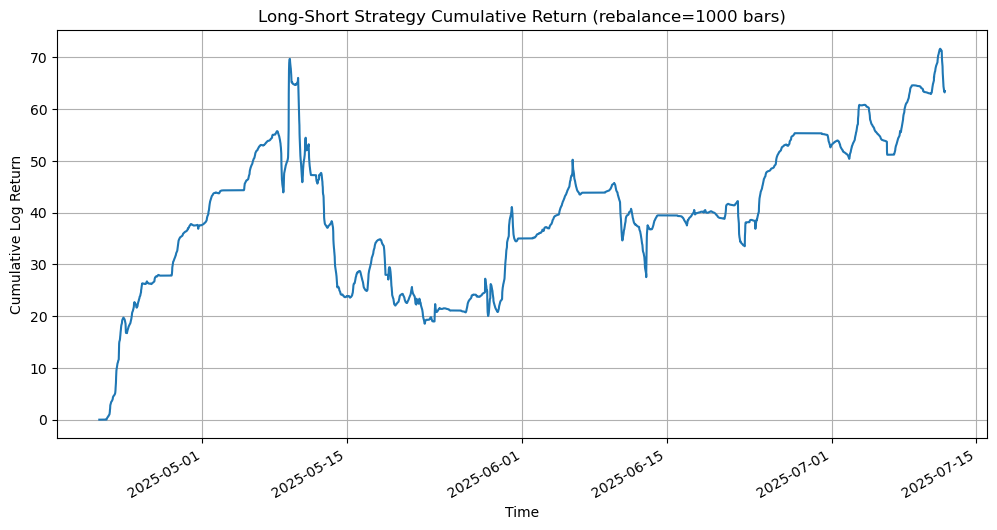

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 假设 full_df 已经包含了：
#   - 'timestamp'（时间戳，可转为 datetime）
#   - 'symbol_enc'（币种编码）
#   - 'px'（当期价格）
#   - 'predicted_label'（模型预测的 rank_label，0=最差、3=最好，或你自己定义的分类）

# 1. 把 timestamp 转成 datetime（便于画图）
full_df['dt'] = pd.to_datetime(full_df['timestamp'], unit='ms')  # 如果是毫秒
# 或者： pd.to_datetime(full_df['timestamp'])

# 2. 排序、去重时间戳
# full_df = full_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
# timestamps = full_df['dt'].drop_duplicates().sort_values().to_list()

# 3. 调仓时间点：每 n 个 timestamp 选一次
n = 1000
rebalance_times = timestamps[::n]

# 4. 生成调仓信号：对每个调仓点选 best_label 做多、worst_label 做空
position_signals = {}
for t in rebalance_times:
    grp = full_df[full_df['dt'] == t]
    if grp.empty:
        continue
    # 分类标签越大表示越好
    best = grp.loc[grp['predicted_label'].idxmax(), 'symbol_enc']
    worst = grp.loc[grp['predicted_label'].idxmin(), 'symbol_enc']
    position_signals[t] = {'long': best, 'short': worst}

# 5. 构建逐行持仓：当前行持有该行所在区间最近一次调仓信号
full_df['long_pos']  = np.nan
full_df['short_pos'] = np.nan

current_long  = None
current_short = None
reb_i = 0

for dt in timestamps:
    if reb_i < len(rebalance_times) and dt == rebalance_times[reb_i]:
        sig = position_signals.get(dt, {})
        current_long  = sig.get('long',  current_long)
        current_short = sig.get('short', current_short)
        reb_i += 1
    # 给当行赋持仓
    mask = full_df['dt'] == dt
    full_df.loc[mask, 'long_pos']  = current_long
    full_df.loc[mask, 'short_pos'] = current_short

# 6. 计算每条数据的 log_return
full_df['log_px']      = np.log(full_df['px'])
full_df['log_px_prev'] = full_df.groupby('symbol_enc')['log_px'].shift(n)
full_df['log_ret']     = full_df['log_px'] - full_df['log_px_prev']

# 7. 计算持仓真实收益
def pos_ret(row):
    if row['symbol_enc'] == row['long_pos']:
        return row['log_ret']
    elif row['symbol_enc'] == row['short_pos']:
        return -row['log_ret']
    else:
        return 0

tqdm.pandas()
full_df['pos_ret'] = full_df.progress_apply(pos_ret, axis=1)

# 8. 聚合到每个调仓区间（或每天）计算策略收益
strat_ret = full_df.groupby('dt')['pos_ret'].mean()

# 9. 绩效指标函数
def perf_stats(return_series, periods_per_year=365*24*6):
    # periods_per_year: 如果你的timestamp是10分钟一档，那么一年大约 365*24*6=52560 档
    cum_ret = return_series.cumsum()
    total_return = cum_ret.iloc[-1]
    ann_return = total_return / len(return_series) * periods_per_year
    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol>0 else np.nan
    # 最大回撤
    running_max = cum_ret.cummax()
    drawdown = cum_ret - running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

stats = perf_stats(strat_ret)
print(pd.Series(stats))

# 10. 绘制累计收益
plt.figure(figsize=(12, 6))
strat_ret.cumsum().plot()
plt.title(f"Long-Short Strategy Cumulative Return (rebalance={n} bars)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.grid(True)
plt.show()


Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 372.68it/s]



--- Strategy Performance Statistics ---
Cumulative Return        0.155538
Annualized Return        0.084191
Annualized Volatility    0.085028
Sharpe Ratio             0.990154
Max Drawdown            -0.056281
dtype: float64


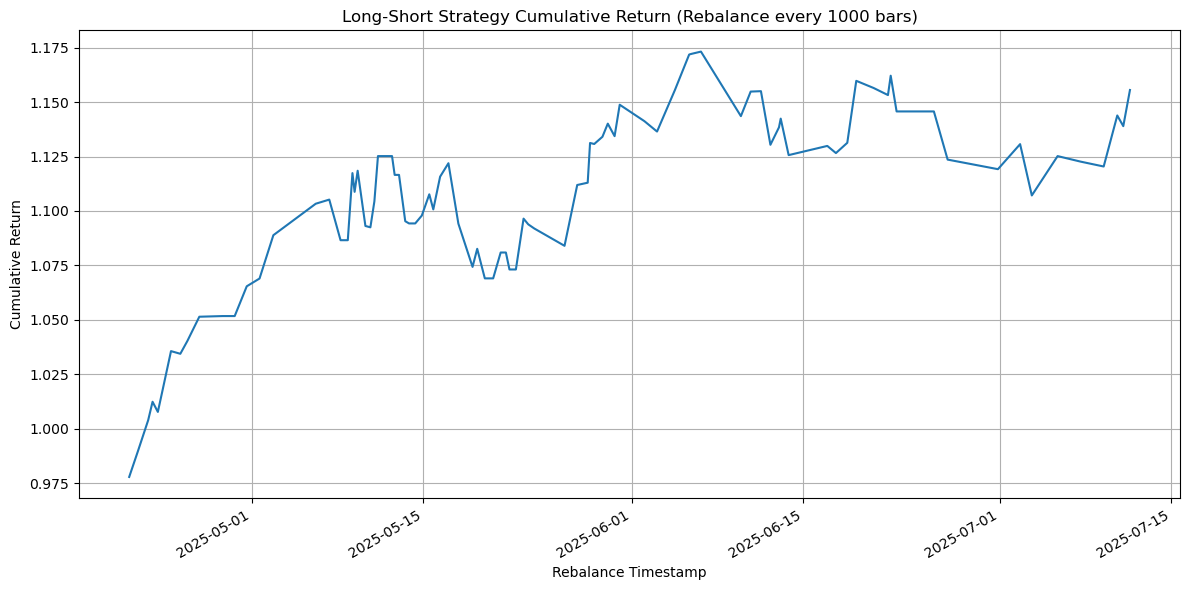

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp': 原始时间戳（例如毫秒），唯一且递增
# - 'symbol_enc': 币种编码
# - 'px': 当期价格
# - 'predicted_label': 模型预测的标签（分类或排名），越大表示越好

# --- 配置参数 ---
N_INTERVAL = 1000 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次

# --- 数据预处理 ---
# 1. 转换时间戳为 datetime 类型，方便处理和绘图
full_df['dt'] = pd.to_datetime(full_df['timestamp'], unit='ms')

# 2. 确保数据按时间戳和币种排序，这是后续分组和shift操作的基础
full_df = full_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# 3. 获取所有唯一的、排序后的时间戳列表
timestamps_sorted = full_df['dt'].drop_duplicates().sort_values().to_list()

# 4. 确定所有调仓时间点
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
# 记录每个调仓时间点应持有的多空币种
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    # 筛选出当前调仓时间点 t 的所有币种数据（截面数据）
    current_snapshot = full_df[full_df['dt'] == t]
    if current_snapshot.empty:
        continue

    # 找出 predicted_label 最高（最好）和最低（最差）的币种
    # 使用 .idxmax() 和 .idxmin() 找到索引，再用 .loc[] 提取 symbol_enc
    long_symbol = current_snapshot.loc[current_snapshot['predicted_label'].idxmax(), 'symbol_enc']
    short_symbol = current_snapshot.loc[current_snapshot['predicted_label'].idxmin(), 'symbol_enc']

    rebalance_signals[t] = {'long': long_symbol, 'short': short_symbol}

# --- 构建调仓周期内的持仓和计算周期收益 ---
# 存储每个调仓周期的策略收益
period_returns = []

# 初始化当前持仓，确保从第一个调仓点开始生效
current_long_symbol = None
current_short_symbol = None

# 遍历每个调仓周期
for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    # 确定当前调仓周期结束时间
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 从 rebalance_signals 获取当前周期的多空币种
    if start_time in rebalance_signals:
        current_long_symbol = rebalance_signals[start_time]['long']
        current_short_symbol = rebalance_signals[start_time]['short']
    else:
        # 如果当前调仓点没有信号（不应发生），则沿用上一个周期的头寸或保持空仓
        # 这里为了简化，假设如果有信号就会找到，没有则保持上一个有效头寸
        # 如果需要严格空仓，可以在这里设置 current_long_symbol = None, current_short_symbol = None
        pass

    # 如果没有有效头寸，跳过此周期（收益为0）
    if current_long_symbol is None or current_short_symbol is None:
        period_returns.append({'dt': start_time, 'strategy_log_return': 0.0})
        continue

    # 筛选出当前调仓周期内的所有数据
    # 包括起始时间点（进行调仓），但不包括结束时间点（结算）
    period_data = full_df[(full_df['dt'] >= start_time) & (full_df['dt'] <= end_time)].copy()

    # 获取多头和空头币种在该周期开始和结束时的价格
    long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]
    long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]

    short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]
    short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]

    # 计算多头和空头在该周期内的对数收益率
    long_log_ret = np.log(long_end_px) - np.log(long_start_px)
    short_log_ret = np.log(short_end_px) - np.log(short_start_px)

    # 计算策略在该周期内的总对数收益（多头收益 + 空头收益的绝对值）
    # 假设各持仓权重相等，所以是 (多头收益 - 空头收益) / 2
    # 或者说，做多一个，做空一个，组合总收益
    strategy_period_log_return = (long_log_ret - short_log_ret) / 2 # 平均对冲策略

    period_returns.append({
        'dt': start_time,
        'strategy_log_return': strategy_period_log_return
    })

# 将周期收益转换为 DataFrame
strategy_returns_df = pd.DataFrame(period_returns).set_index('dt')
strategy_returns_series = strategy_returns_df['strategy_log_return']

# --- 绩效指标函数 ---
def perf_stats(return_series, periods_per_year):
    """
    计算并返回策略的绩效统计数据。
    return_series: 每个周期的对数收益率序列。
    periods_per_year: 一年内有多少个这样的周期（用于年化）。
    """
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp) # 对数收益累加后转回普通收益
    total_return = cum_ret.iloc[-1] - 1 # 累计普通收益

    # 年化收益率 (几何平均)
    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year) # 年化波动率
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    # 最大回撤 (基于普通收益)
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# 假设每个时间戳是10分钟，N_INTERVAL=1000，则一个周期是 1000 * 10分钟 = 10000 分钟
# 一年大约有 52560 个10分钟的间隔 (365天 * 24小时 * 6个10分钟/小时)
# 则一年大约有 52560 / 1000 = 52.56 个 N_INTERVAL 周期
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 10分钟一档
# 或者更直接： (总时间戳数 / N_INTERVAL) / 总年数

stats = perf_stats(strategy_returns_series, periods_per_year_for_annualization)
print("\n--- Strategy Performance Statistics ---")
print(pd.Series(stats))

# --- 绘制累计收益曲线 ---
plt.figure(figsize=(12, 6))
# 对数收益累加，然后取指数，得到累计普通收益曲线
strategy_returns_series.cumsum().apply(np.exp).plot()
plt.title(f"Long-Short Strategy Cumulative Return (Rebalance every {N_INTERVAL} bars)")
plt.xlabel("Rebalance Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df

In [ ]:
print("总样本数：", len(full_df))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已有 df，包含 symbol_enc、timestamp、true_label、predicted_prob、px、position（自行添加）
# 转换 timestamp 为时间格式（如需要）
df = full_df
df["timestamp"] = pd.to_datetime(full_df["timestamp"], unit="ms")

# 遍历每个币种
symbols = df["symbol_enc"].unique()
fig, axs = plt.subplots(len(symbols), 1, figsize=(14, 3 * len(symbols)), sharex=True)

if len(symbols) == 1:
    axs = [axs]

for i, sym in enumerate(symbols):
    sym_df = df[df["symbol_enc"] == sym].copy()
    
    ax = axs[i]
    ax.set_title(f"Symbol {sym}")
    
    # 主轴: 价格
    ax.plot(sym_df["timestamp"], sym_df["px"], label="Price", color="black")
    ax.set_ylabel("Price", color="black")
    ax.tick_params(axis='y', labelcolor='black')

    # 第二轴: label
    ax2 = ax.twinx()
    ax2.plot(sym_df["timestamp"], sym_df["true_label"], label="Label", color="blue", alpha=0.6)
    ax2.set_ylabel("Label", color="blue")
    ax2.tick_params(axis='y', labelcolor='blue')

    # 第三轴: predicted prob
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.1))  # 偏移右边
    ax3.plot(sym_df["timestamp"], sym_df["predicted_prob"], label="Pred Prob", color="orange", alpha=0.6)
    ax3.set_ylabel("Predicted", color="orange")
    ax3.tick_params(axis='y', labelcolor='orange')

    # 第四轴: position（如果你有这个字段）
    if "position" in sym_df.columns:
        ax4 = ax.twinx()
        ax4.spines.right.set_position(("axes", 1.2))  # 更偏移右边
        ax4.plot(sym_df["timestamp"], sym_df["position"], label="Position", color="green", alpha=0.6)
        ax4.set_ylabel("Position", color="green")
        ax4.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import spearmanr

ic_list = []
time_list = []

for ts, group in full_df.groupby('timestamp'):
    if len(group) < 2:
        continue
    # 检查是否有变化
    if group['predicted_prob'].nunique() < 2 or group['true_label'].nunique() < 2:
        # 预测值或真实标签没有变化，跳过
        continue
    ic, _ = spearmanr(group['predicted_prob'], group['true_label'])
    ic_list.append(ic)
    time_list.append(ts)


print(f"平均IC: {np.mean(ic_list):.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

ic_list = []
time_list = []

# 计算每个时间截面的 IC
for ts, group in full_df.groupby('timestamp'):
    if len(group) < 2:
        continue
    if group['predicted_prob'].nunique() < 2 or group['true_label'].nunique() < 2:
        continue
    ic, _ = spearmanr(group['predicted_prob'], group['true_label'])
    ic_list.append(ic)
    time_list.append(ts)

# 转为 np.array 和 datetime 格式（如需要）
ic_array = np.array(ic_list)
time_array = np.array(time_list)

# 排序时间（可选，保险做法）
sorted_idx = np.argsort(time_array)
time_array = time_array[sorted_idx]
ic_array = ic_array[sorted_idx]

# 计算累计 IC（cum IC）
cum_ic = np.cumsum(ic_array)

# 计算 IR（信息比率 = 平均IC / IC标准差）
ir = np.mean(ic_array) / np.std(ic_array)

# 打印信息
print(f"平均IC: {np.mean(ic_array):.4f}")
print(f"平均IC std: {np.std(ic_array):.4f}")

print(f"信息比率 IR: {ir:.4f}")

# 每隔500点采样一次
step = 500
time_array_sampled = time_array[::step]
ic_array_sampled = ic_array[::step]
cum_ic_sampled = cum_ic[::step]

# 绘图
plt.figure(figsize=(14, 6))

# 子图1: IC 时间序列图（采样后）
plt.subplot(2, 1, 1)
plt.plot(time_array_sampled, ic_array_sampled, marker='o', label='IC')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Information Coefficient (IC) over Time (sampled every 500 points)")
plt.ylabel("IC")
plt.legend()

# 子图2: 累积 IC 图（采样后）
plt.subplot(2, 1, 2)
plt.plot(time_array_sampled, cum_ic_sampled, color='orange', label='Cumulative IC')
plt.title(f"Cumulative IC (IR={ir:.4f})")
plt.xlabel("Time")
plt.ylabel("Cumulative IC")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

n = N  # 调仓周期，间隔几个时间点调一次

# 对timestamp排序并去重，方便切片
timestamps = sorted(full_df['timestamp'].unique())

# 每n个时间点取一次作为调仓点
rebalance_times = timestamps[::n]

# 记录每个时间点对应的仓位信号（多头做多 +1，空头做空 -1，其他无仓位）
position_signals = {}

for t in tqdm(rebalance_times, desc="Rebalancing"):
    # 取调仓时间点对应截面
    group = full_df[full_df['timestamp'] == t]
    if group.empty:
        continue
    # 最高预测币种做多 +1
    long_symbol = group.loc[group['predicted_prob'].idxmax()]['symbol_enc']
    # 最低预测币种做空 -1
    short_symbol = group.loc[group['predicted_prob'].idxmin()]['symbol_enc']
    position_signals[t] = {'long': long_symbol, 'short': short_symbol}

# 对所有时间点，确定持仓（调仓信号持有直到下一次调仓）
positions = []

for i, ts in tqdm(enumerate(timestamps), total=len(timestamps), desc="Building positions"):
    rebalance_idx = (i // n) * n
    rebalance_ts = timestamps[rebalance_idx]
    if rebalance_ts not in position_signals:
        positions.append({'timestamp': ts, 'long': None, 'short': None})
        continue
    signals = position_signals[rebalance_ts]
    positions.append({'timestamp': ts, 'long': signals['long'], 'short': signals['short']})

positions_df = pd.DataFrame(positions)

# 把持仓信息merge回full_df
full_df_b = full_df.merge(positions_df, on='timestamp', how='left')

tqdm.pandas(desc="Computing returns")


# 计算持仓收益
def compute_return(row):
    if row['symbol_enc'] == row['long']:
        return row['true_label']  # 多头收益
    elif row['symbol_enc'] == row['short']:
        return -row['true_label']  # 空头收益
    else:
        return 0

full_df_b['position_return'] = full_df_b.progress_apply(compute_return, axis=1)

# 按时间点求组合收益
daily_return = full_df_b.groupby('timestamp')['position_return'].mean()

# 计算累计收益
cum_return = daily_return.cumsum()

# 画累计收益曲线
cum_return.plot()
plt.title(f"Long-Short Cumulative Return, Rebalance every {n} timestamps")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative Return")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 假设 N 是调仓周期，间隔多少个时间点调仓一次
n = N   # 你实际使用时替换为数字，比如 n = 500
n = 1000
# 按时间排序，去重，得到所有唯一时间戳
timestamps = sorted(full_df['timestamp'].unique())

# 每 n 个时间点取一个调仓点
rebalance_times = timestamps[::n]

# 记录调仓时间点对应的持仓信号：多头long和空头short（symbol_enc编码）
position_signals = {}

for t in tqdm(rebalance_times, desc="Rebalancing"):
    group = full_df[full_df['timestamp'] == t]
    if group.empty:
        continue
    # 最高预测概率币种做多
    long_symbol = group.loc[group['predicted_prob'].idxmax()]['symbol_enc']
    # 最低预测概率币种做空
    short_symbol = group.loc[group['predicted_prob'].idxmin()]['symbol_enc']
    position_signals[t] = {'long': long_symbol, 'short': short_symbol}

# 根据调仓信号构建所有时间点的持仓（持仓信号从调仓时间点持有至下一调仓时间点）
positions = []
for i, ts in tqdm(enumerate(timestamps), total=len(timestamps), desc="Building positions"):
    rebalance_idx = (i // n) * n
    rebalance_ts = timestamps[rebalance_idx]
    if rebalance_ts not in position_signals:
        positions.append({'timestamp': ts, 'long': None, 'short': None})
        continue
    signals = position_signals[rebalance_ts]
    positions.append({'timestamp': ts, 'long': signals['long'], 'short': signals['short']})

positions_df = pd.DataFrame(positions)

# 合并持仓信号回原始数据
full_df_b = full_df.merge(positions_df, on='timestamp', how='left')

# 按币种和时间排序，计算价格对数和对数收益率
full_df_b = full_df_b.sort_values(['symbol_enc', 'timestamp']).reset_index(drop=True)
full_df_b['log_px'] = np.log(full_df_b['px'])
full_df_b['log_px_prev'] = full_df_b.groupby('symbol_enc')['log_px'].shift(1)
full_df_b['log_return'] = full_df_b['log_px'] - full_df_b['log_px_prev']

# 计算持仓对应的真实收益
def compute_real_return(row):
    if row['symbol_enc'] == row['long']:
        return row['log_return']  # 多头收益
    elif row['symbol_enc'] == row['short']:
        return -row['log_return']  # 空头收益
    else:
        return 0

tqdm.pandas(desc="Computing position returns (price-based)")
full_df_b['position_return_real'] = full_df_b.progress_apply(compute_real_return, axis=1)

# 按时间点聚合，计算每日（每时间戳）组合平均收益
daily_return_real = full_df_b.groupby('timestamp')['position_return_real'].mean()

# 计算累计收益
cum_return_real = daily_return_real.cumsum()

# 绘制累计收益曲线
plt.figure(figsize=(12,6))
cum_return_real.plot()
plt.title(f"Long-Short Cumulative Return (Price-based), Rebalance every {n} timestamps")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()


In [ ]:
print(positions_df)
print(positions_df['long'].unique())
print(positions_df['short'].unique())
print(positions_df.dtypes)


In [ ]:
# # 假设手续费比例（双边，比如买卖各0.05%）
# fee_rate = 0.0005  # 0.05%

# # 计算每日仓位变化：long和short的仓位和上一期相比是否变化了
# positions_df = positions_df.sort_values('timestamp').reset_index(drop=True)

# positions_df['long_prev'] = positions_df['long'].shift(1)
# positions_df['short_prev'] = positions_df['short'].shift(1)

# # 计算换仓数量（这里简化为long和short是否变化，变化即扣手续费）
# positions_df['long_changed'] = positions_df['long'] != positions_df['long_prev']
# positions_df['short_changed'] = positions_df['short'] != positions_df['short_prev']

# # 每个时间点总换仓笔数
# positions_df['num_trades'] = positions_df['long_changed'].astype(int) + positions_df['short_changed'].astype(int)

# # 合并回full_df_b
# full_df_b = full_df.merge(positions_df[['timestamp', 'long', 'short', 'num_trades']], on='timestamp', how='left')

# tqdm.pandas(desc="Computing returns with fees")

# def compute_return_with_fee(row):
#     ret = 0
#     if row['symbol_enc'] == row['long']:
#         ret = row['true_label']
#     elif row['symbol_enc'] == row['short']:
#         ret = -row['true_label']

#     # 按时间点平均分配手续费（假设所有币种均摊手续费）
#     fee_cost = row['num_trades'] * fee_rate / full_df_b['symbol_enc'].nunique()
#     return ret - fee_cost

# full_df_b['position_return_fee'] = full_df_b.progress_apply(compute_return_with_fee, axis=1)

# daily_return_fee = full_df_b.groupby('timestamp')['position_return_fee'].mean()
# cum_return_fee = daily_return_fee.cumsum()

# cum_return_fee.plot()
# plt.title(f"Long-Short Cumulative Return with Fees, Rebalance every {n} timestamps")
# plt.xlabel("Timestamp")
# plt.ylabel("Cumulative Return")
# plt.show()


In [ ]:
long_counts = positions_df['long'].value_counts().sort_index()
short_counts = positions_df['short'].value_counts().sort_index()

print("多头持仓分布（币种编码及对应持仓时间点数）:")
print(long_counts)

print("\n空头持仓分布（币种编码及对应持仓时间点数）:")
print(short_counts)


In [ ]:
positions_df = positions_df.sort_values('timestamp').reset_index(drop=True)
positions_df['long_prev'] = positions_df['long'].shift(1)
positions_df['short_prev'] = positions_df['short'].shift(1)

positions_df['long_changed'] = positions_df['long'] != positions_df['long_prev']
positions_df['short_changed'] = positions_df['short'] != positions_df['short_prev']

positions_df['num_trades'] = positions_df['long_changed'].astype(int) + positions_df['short_changed'].astype(int)

print(positions_df[['timestamp', 'long', 'long_prev', 'long_changed', 'short', 'short_prev', 'short_changed', 'num_trades']].head(20))
total_trades = positions_df['num_trades'].sum()
print(f"总调仓次数: {total_trades}")
long_duration = positions_df.groupby('long').size()
short_duration = positions_df.groupby('short').size()

print("币种被做多的时间点数量（时长）:")
print(long_duration)

print("\n币种被做空的时间点数量（时长）:")
print(short_duration)


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
long_counts.plot(kind='bar', ax=axes[0], title='long')
short_counts.plot(kind='bar', ax=axes[1], title='short')
plt.show()


In [ ]:
total_timepoints = len(positions_df)

long_ratio = long_counts / total_timepoints
short_ratio = short_counts / total_timepoints

print("多头持仓比例：")
print(long_ratio)

print("\n空头持仓比例：")
print(short_ratio)


In [ ]:
cum_return